# Prague Marathon Results
## Data Analysis
#### David Koubek, Jiri Zelenka

In this data analysis, we load the 24 datasets that the scraper scraped from the RunCzech website. Then we treat/clean the data from missing values, preprocess it (adding Gender column inferred from "Age category", visualise various statistics about the data, and finally analyse the finishing times, trying to do just a basic rough prediction when the 2 hour marathon mark could be broken in the future. We have just 24 years, so it is not really enough observations to extrapolate anything into the future. Nonetheless, regarding the nature of sports, it is rather safe to guess that the physical boundaries of human body will be further pushed through precise training methods and improving nutrition and regeneration. The 2 hour mark is just a minute and a half away (although our Prague marathon doesn't host the world times and is a little behind). At the time of writing, the best time of 2h:01m:39s was achieved in Berlin marathon in 2018.

### Content of Analysis:

#### Import of Required Packages
##### Setup for the basic graphs
#### Data Loading + Merging
-------------------------------------
#### Preprocessing:

###### 1 Renaming Columns
###### 2 Cleaning Time + Adding Hours Column
###### 3 Cleaning Names of Runners + Completing Missing Ranks
###### 4 Adding Gender + Additional Genders 
-------------------------------------
#### Unique Countries, Names and Ages
#### Runners who Repeated Marathon
#### Top 5 Countries with the Most of Runners
#### Percentage of Czechs Over Time
-------------------------------------
#### Pivot Tables - Year x Gender
###### Min rank, Min time, Median time
###### Men x Women boxplots
-------------------------------------
#### Histograms 1995,2019, Total 
-------------------------------------
#### Predictions, 2 hour goal
-------------------------------------
-------------------------------------

### Import of Required Packages

In [1]:
import pandas as pd                            # for dataframe
import numpy as np                             # working with arrays
import matplotlib.pyplot as plt                # Basic plots
import seaborn as sns                          # Plots, boxplots
import gender_guesser.detector as gender       # Gender predictions
from collections import Counter                # Counting items in set
from sklearn.linear_model import LinearRegression  # Liear model and predictions
from scipy import stats                        # Liear model and predictions

##### Setup  for the basic graphs



In [2]:
plt.rcParams["figure.figsize"]=(14,8)

### Data loading + Merging

#### 1995 - 2019 (excluding 2012)

In [3]:
years = [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
         2005, 2006, 2007, 2008, 2009, 2010, 2011, 
         2013, 2014, 2015, 2016, 2017, 2018, 2019]

# 2012 is missing !!!, 24 runs


df_all = []
path = '../Scraper/Data_Marathons_Prague/data_'

for i in years:
    df = pd.read_csv(path + str(i) + '.csv')
    df["Year"] = i
    df_all.append(df)
    

df_merged = pd.concat(df_all, ignore_index=True)   
# Reseting Index to obtain overall indexes

len(df_merged)
# Total number of records = 94 299

94299

In [4]:
df_merged.head()
df_merged.tail()

# First glimpses into dataset

,Rank,Name,Chip time,St. number,Nationality,Age cat.,Year
94294,7296,Jaroslav Sopuch,6:45:30,4652,SVK,M65,2019
94295,7297,Dong Tran,6:39:37,7542,VNM,MAM,2019
94296,7298,Jiří Přidal,6:57:39,6743,CZE,M65,2019
94297,7299,Iva Valentová,6:42:54,F2060,CZE,W45,2019
94298,7300,EHUD AVNI,6:59:04,7331,ISR,M50,2019


## Preprocessing

#### 1 Renaming Columns
#### 2 Cleaning Time + Adding Hours Column#### 2 
#### 3 Cleaning Names of Runners + Completing Missing Ranks
#### 4 Adding Gender + Additional Genders 


### 1 Renaming Columns


In [5]:
df_renamed =df_merged.copy()

df_renamed = df_renamed.rename(columns={"Age cat.":"Age", "Chip time":"Time","St. number":"Start_number"  })

df_renamed.head()
df_renamed.tail()

,Rank,Name,Time,Start_number,Nationality,Age,Year
94294,7296,Jaroslav Sopuch,6:45:30,4652,SVK,M65,2019
94295,7297,Dong Tran,6:39:37,7542,VNM,MAM,2019
94296,7298,Jiří Přidal,6:57:39,6743,CZE,M65,2019
94297,7299,Iva Valentová,6:42:54,F2060,CZE,W45,2019
94298,7300,EHUD AVNI,6:59:04,7331,ISR,M50,2019


### 2 Cleaning Time + Adding Hours Column
###### We deleted 288 observations with blank time, mostly from year 1998.
###### These were not suitable for further analysis

In [6]:
# Deleting 288 observations with time = "-" - mostly from year 1998, reason of this = ???

df_times = df_renamed.copy()
df_times = df_times[df_renamed.Time != "-"]

df_times.reset_index(drop = True,inplace=True)

# Check for non-"-" times
times = df_times["Time"]
times.describe()

len(df_times)

# Keep working with 94 011 Runners

94011

### 2.2 Adding Min Column

In [7]:
# Counting minutes from Total time

tot_min = []
times = list(times)

for i in times:
    t=i.split(':')
    tot_min.append(int(t[0])*60+int(t[1])*1 +int(t[2])/60)
    
# len(tot_min)
tot_min = pd.DataFrame(tot_min)

df_mins = pd.concat([df_times, tot_min], axis=1)
df_mins = df_mins.rename(columns={0:"tot_mins"})

In [8]:
# List of roudned minutes

Mins = list(np.around(np.array(tot_min),0))
Mins = pd.DataFrame(Mins)

df_mins = pd.concat([df_mins, Mins], axis=1)
df_mins = df_mins.rename(columns={0:"Mins"})

df_mins.head()
# df_mins.tail()

# Keep working with Dataframe including rounded minutes

,Rank,Name,Time,Start_number,Nationality,Age,Year,tot_mins,Mins
0,1,Turbo Tummo,2:12:44,3,-,-,1995,132.733333,133.0
1,2,Andrzej Krzyscin,2:16:53,8,-,-,1995,136.883333,137.0
2,3,Pavel Klimes,2:16:56,7,-,-,1995,136.933333,137.0
3,4,Miriusz Kaminski,2:17:06,28,-,-,1995,137.100000,137.0
4,5,Jackson Kipngok,2:17:13,1,-,-,1995,137.216667,137.0


###  3 Cleaning Names of Runners + Completing Missing Ranks

In [9]:
all_names = list(df_mins.Name)

print(sorted(df_mins)[0:500])
print(sorted(df_mins)[len(df_mins)-500:len(all_names)])

    # In the head we can see some names starting with spaces or dots - we will transform them in next step
    # In the tail there are names of Russian, Israeli, Chiense or Japanese Runners
    # There are not so many of them, we keep them in original form

['Age', 'Mins', 'Name', 'Nationality', 'Rank', 'Start_number', 'Time', 'Year', 'tot_mins']
[]


In [10]:
df_named = df_mins.copy()

indd = df_named.index[df_named['Name'] == ' Peter Puškár                   '].tolist()
df_named.loc[indd,'Name'] = "Peter Puškár"
indd = df_named.index[df_named['Name'] == ' Radek Podracký               '].tolist()
df_named.loc[indd,'Name'] = "Radek Podracký"
indd = df_named.index[df_named['Name'] == ' STEINIVAR'].tolist()
df_named.loc[indd,'Name'] = "STEINIVAR"
indd = df_named.index[df_named['Name'] == ',Jiří Stránský Judr.'].tolist()
df_named.loc[indd,'Name'] = "Jiří Stránský Judr."
indd = df_named.index[df_named['Name'] == '.Jiří Nekuža'].tolist()
df_named.loc[indd,'Name'] = "Jiří Nekuža"
indd = df_named.index[df_named['Name'] == '- 50008873'].tolist()
df_named.loc[indd,'Name'] = "- -"
indd = df_named.index[df_named['Name'] == '- 50044654'].tolist()
df_named.loc[indd,'Name'] = "- -"
indd = df_named.index[df_named['Name'] == '?IVIND JOHANSEN'].tolist()
df_named.loc[indd,'Name'] = "IVIND JOHANSEN"
indd = df_named.index[df_named['Name'] == '\u202aesty rosenberg\u202c\u200f'].tolist()
df_named.loc[indd,'Name'] = "aesty rosenberg"
indd = df_named.index[df_named['Name'] == '\u202aron gashri\u202c\u200f'].tolist()
df_named.loc[indd,'Name'] = "aron gashri"
indd = df_named.index[df_named['Name'] == 'ＨＩＲＯＫＯ ＫＵＳＵＮＯＫＩ'].tolist()
df_named.loc[indd,'Name'] = "Hiroko Kusunoki"
indd = df_named.index[df_named['Name'] == 'ＨＩＲＯＫＯ ＳＨＩＮＯＭＩＹＡ'].tolist()
df_renamed.loc[indd,'Name'] = "Hiroko Shinomiya"
indd = df_named.index[df_named['Name'] == 'ＨＩＲＯＭＩ ＹＯＮＥＺＵ'].tolist()
df_named.loc[indd,'Name'] = "Hiromi Yonezu"
indd = df_named.index[df_named['Name'] == 'ＪＵＮＫＯ ＮＩＳＨＩＯＫＡ'].tolist()
df_named.loc[indd,'Name'] = "Junko Nishioka"
indd = df_named.index[df_named['Name'] == 'ＫＩＳＡＫＯ ＴＯＫＯ'].tolist()
df_named.loc[indd,'Name'] = "Kisako Toko"
indd = df_named.index[df_named['Name'] == 'ＫＩＹＯＫＯ ＫＡＷＡＳＡＫＩ'].tolist()
df_named.loc[indd,'Name'] = "Kiyoko Kawasaki"
indd = df_named.index[df_named['Name'] == 'ＭＡＳＡＫＯ ＯＮＩＳＨＩ'].tolist()
df_named.loc[indd,'Name'] = "Masako Onishi"
indd = df_named.index[df_named['Name'] == 'ＭＩＥＫＯ ＴＳＵＪＩＯＫＡ'].tolist()
df_named.loc[indd,'Name'] = "Mieko Tsujioka"

In [11]:
df_named['Name'] = [str(i).lower() for i in df_named['Name']] 
# Changing all Names to lowercase
    
df_named.head()

,Rank,Name,Time,Start_number,Nationality,Age,Year,tot_mins,Mins
0,1,turbo tummo,2:12:44,3,-,-,1995,132.733333,133.0
1,2,andrzej krzyscin,2:16:53,8,-,-,1995,136.883333,137.0
2,3,pavel klimes,2:16:56,7,-,-,1995,136.933333,137.0
3,4,miriusz kaminski,2:17:06,28,-,-,1995,137.100000,137.0
4,5,jackson kipngok,2:17:13,1,-,-,1995,137.216667,137.0


In [12]:
len(df_named)

94011

In [ ]:
# df_named[df_named["Rank"]=="-"]

### 3.2 Completing Missing Ranks

The only missing ranks are important for year 1997.
The rest of the missing ranks has missing time, too, and it will be dropped at all.

In [14]:
df_ranks = df_named.copy()
df_ranks = df_ranks[df_ranks["Time"] != "-"]
# Dropping observaitons of 1998 having no times

missing_ranks = list(range(1601,1640))
missing_ranks = list(map(str, missing_ranks))
# Changing range of ranks into Strings

len(missing_ranks)
len(df_ranks.loc[df_ranks['Rank']=="-","Rank"])
# Check of the length of source and target => OK

df_ranks.loc[df_ranks['Rank']=="-", "Rank"] = missing_ranks
# Applying new ranks into the missing places

df_ranks["Rank"] = pd.to_numeric(df_ranks["Rank"])
# This improved our further analysis of Pivot tables, some Ranks were not in number format

df_ranks[df_ranks["Year"]==1997].tail(40)
# Check of the new Ranks

,Rank,Name,Time,Start_number,Nationality,Age,Year,tot_mins,Mins
3285,1600,barbora dohnalová,5:10:36,393,TCH,WAM,1997,310.600000,311.0
3286,1601,jan prosecký,5:10:43,3857,TCH,MAM,1997,310.716667,311.0
3287,1602,véronique bruneau,5:12:46,336,FRA,WAM,1997,312.766667,313.0
3288,1603,jiří mareš,5:12:57,3760,TCH,MAM,1997,312.950000,313.0
3289,1604,miloslav kníže,5:12:58,3639,TCH,MAM,1997,312.966667,313.0
3290,1605,ladislav hnízdil,5:14:31,2975,TCH,M60,1997,314.516667,315.0
3291,1606,melissa stark,5:16:11,319,GBR,WAM,1997,316.183333,316.0
3292,1607,eduard bartek,5:16:12,3511,TCH,MAM,1997,316.200000,316.0
3293,1608,josef kocourek,5:16:17,3652,TCH,MAM,1997,316.283333,316.0
3294,1609,miroslav hofman,5:16:33,3859,TCH,M40,1997,316.550000,317.0


### 4 Adding Gender + Additional Genders

In [15]:
df_gend = df_ranks.copy()

df_gend["Gender"] = df_gend["Age"].astype(str).str[0]
# Adding Gender column based on the first letter of Age code 

df_gend.tail()

,Rank,Name,Time,Start_number,Nationality,Age,Year,tot_mins,Mins,Gender
94006,7296,jaroslav sopuch,6:45:30,4652,SVK,M65,2019,405.500000,406.0,M
94007,7297,dong tran,6:39:37,7542,VNM,MAM,2019,399.616667,400.0,M
94008,7298,jiří přidal,6:57:39,6743,CZE,M65,2019,417.650000,418.0,M
94009,7299,iva valentová,6:42:54,F2060,CZE,W45,2019,402.900000,403.0,W
94010,7300,ehud avni,6:59:04,7331,ISR,M50,2019,419.066667,419.0,M


### 4.2 Additional Genders
###### Now we have around 3.300 Runners with missing gender.
###### We will deal with them using gender.Detector() function

In [16]:
Forename = []
for i in df_gend["Name"]:
    nick = i.split(' ')
    Forename.append(nick[0].capitalize())

df_gend["Forename"]=Forename

df_gend.reset_index(drop = True, inplace = True)

df_gend[df_gend["Gender"]=="-"].head()

# Here we generated column of Fornames with capitalized first letters

,Rank,Name,Time,Start_number,Nationality,Age,Year,tot_mins,Mins,Gender,Forename
0,1,turbo tummo,2:12:44,3,-,-,1995,132.733333,133.0,-,Turbo
1,2,andrzej krzyscin,2:16:53,8,-,-,1995,136.883333,137.0,-,Andrzej
2,3,pavel klimes,2:16:56,7,-,-,1995,136.933333,137.0,-,Pavel
3,4,miriusz kaminski,2:17:06,28,-,-,1995,137.100000,137.0,-,Miriusz
4,5,jackson kipngok,2:17:13,1,-,-,1995,137.216667,137.0,-,Jackson


In [17]:
d = gender.Detector()

# This package has satisfying results for both czech and foreign names,
# e.g. Jiří, Ehud, Jindřiška = OK,
# Saša, Dong = both possible genders

for i in range(len(df_gend)):
    #print(i)
    if df_gend.loc[i,"Gender"]=="-":

        new_gender = d.get_gender(df_gend.loc[i,"Forename"])
           
        if new_gender == "male":
            df_gend.loc[i, "Gender"] = "M"
                
        elif new_gender == "female":
            df_gend.loc[i, "Gender"] = "W"

# This part of code generated male/female/other labels,
# which we transformed into M and W labels

len(df_gend[df_gend["Gender"]=="-"])
#There are only 341 Genders missing

341

In [18]:
df_gend[df_gend["Year"]==1995].head()

,Rank,Name,Time,Start_number,Nationality,Age,Year,tot_mins,Mins,Gender,Forename
0,1,turbo tummo,2:12:44,3,-,-,1995,132.733333,133.0,-,Turbo
1,2,andrzej krzyscin,2:16:53,8,-,-,1995,136.883333,137.0,M,Andrzej
2,3,pavel klimes,2:16:56,7,-,-,1995,136.933333,137.0,M,Pavel
3,4,miriusz kaminski,2:17:06,28,-,-,1995,137.100000,137.0,-,Miriusz
4,5,jackson kipngok,2:17:13,1,-,-,1995,137.216667,137.0,M,Jackson


Additionally, we decided to label manually Turbo Tummo,
who won the run in 1995, but due to his unusual name he would stand out of our analysis.

In [19]:
df_gend.loc[0, "Gender"] = "M"

df_final = df_gend.copy()

df_final.head()

,Rank,Name,Time,Start_number,Nationality,Age,Year,tot_mins,Mins,Gender,Forename
0,1,turbo tummo,2:12:44,3,-,-,1995,132.733333,133.0,M,Turbo
1,2,andrzej krzyscin,2:16:53,8,-,-,1995,136.883333,137.0,M,Andrzej
2,3,pavel klimes,2:16:56,7,-,-,1995,136.933333,137.0,M,Pavel
3,4,miriusz kaminski,2:17:06,28,-,-,1995,137.100000,137.0,-,Miriusz
4,5,jackson kipngok,2:17:13,1,-,-,1995,137.216667,137.0,M,Jackson


#### Now we are done with preprocessing
From 3309 missing Genders we now miss only 340 observations of Gender, which is a great improvement!

### Unique Countries, Names and Ages

In [20]:
#All unique countries:

uq_countries = df_final.Nationality.unique()   
len(uq_countries)

#uq_countries = 205

205

In [21]:
# All unique ages:

uq_ages = df_final.Age.unique()
len(uq_ages)

# uq_ages = 15

15

In [22]:
# All unique names:

uq_names = df_final.Name.unique()
len(uq_names)

# uq_names = 66087

66087

### Runners who Repeated Marathon

Here we computed number of repetitions of each name over years
Anyway, we cannot yet say, how many of them are the same name in one run like "Petr Svoboda" 41x during 24 runs,
but there are definitely Runners who took more runs like "jack joseph michel brossaud" - 7x

In [23]:
all_names = list(df_final.Name)
num_of_runs = Counter(all_names)

#num_of_runs.most_common() 
    #This is a list of all Names and their amount of appearence

### Top 5 Countries of origins (icluding Kenya)

In [24]:
all_names = list(df_final.Nationality)
num_of_countries = Counter(all_names)
# This part assigns number of Runners to all countries

numerous_countries = num_of_countries.most_common(50)
numerous_countries = [i[0] for i in numerous_countries]
idx = numerous_countries.index("KEN")
# In this part we obtained index of Kenya in top 50 most 'populated' countries

numerous_countries = num_of_countries.most_common(4)
numerous_countries = [i[0] for i in numerous_countries]
numerous_countries.append("KEN")
# Now we took 4 countries with the most Runners, Kenya was added for comparison as the on with he best Runners

[num_of_countries.most_common(4), (num_of_countries.most_common()[idx])]

[[('CZE', 41671), ('FRA', 6885), ('ITA', 6830), ('GBR', 3950)], ('KEN', 207)]

In [25]:
years = [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
         2005, 2006, 2007, 2008, 2009, 2010, 2011, 
         2013, 2014, 2015, 2016, 2017, 2018, 2019]

years = years[4:]
# Now we start from 1999 because of missing Nationalities in 1995-1998

countries_best =[]

for j in numerous_countries:
    
    nation_tot = []

    for i in years:
        nation = df_final[(df_final["Year"]== i) & (df_final["Nationality"]== j)]
        nation_min = nation.Mins.min()
        nation_tot.append(nation_min)
        
    countries_best.append(nation_tot)   
    
# This code looped over 5 countries and years 1999-2019 and obtained the best times for each country

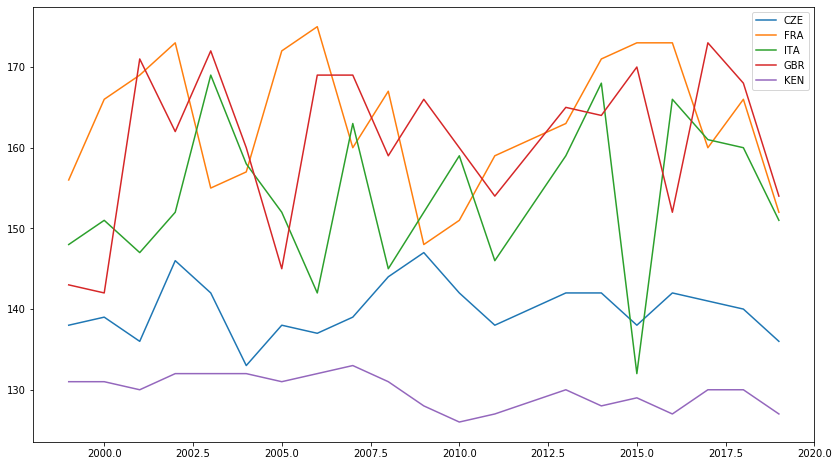

In [26]:
for i in range(len(countries_best)):
    plt.plot(years, countries_best[i])

plt.legend(numerous_countries, loc='upper right')

plt.show()

#### Kenya leads the running times, Czechia holds quiet good results, probably because of the huge amount of Runners. Italy is the only one of the most participating countries, who beat Czechia (in 2015).  

### Percentage of Czechs Over Time

##### After inspecting each year, we noticed of the occurence of "TCH" instead of "CZE" in Nationality column.

###### 1995 - no nationalities
###### 1996 2x CZE + 0x TCH
###### 1997 1x CZE + 727x TCH
###### 1998 1x CZE + 1045x TCH
###### 1999 986x CZE + 0x TCH

In [27]:
# Replacing all "TCH" with "CZE"

df_final['Nationality'] = df_final['Nationality'].replace('TCH', 'CZE') 

In [28]:
# Percents of czech Runners over years 1997-2019

cz_percent = []
for year in years:
    # We keep working with 1997-2019 years set
    
    cz = len(df_final[(df_final["Nationality"] == "CZE") & (df_final["Year"] == year)])
    alls = len(df_final[df_final["Year"] == year])
    per = cz/alls
    cz_percent.append(per)   
    
# cz_percent

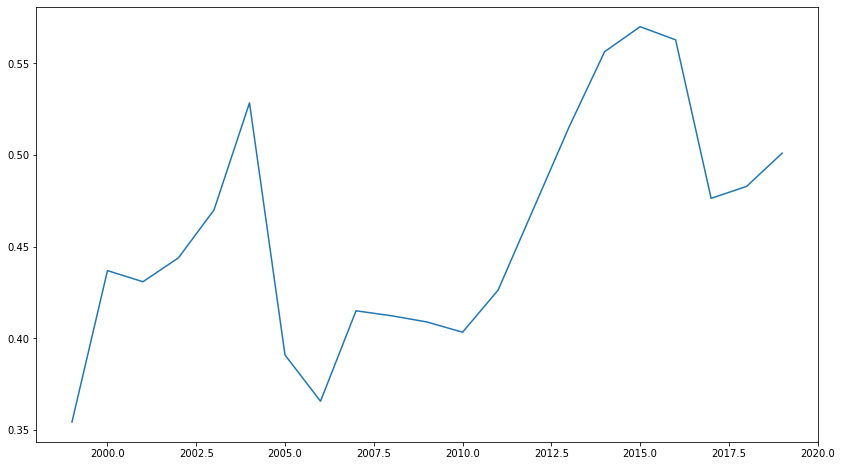

In [29]:
czechs = df_final[df_final["Nationality"] == "CZE"]
len(czechs)/len(df_final)

# Overall percentage of czech Runners = 46.2 %

plt.plot(years, cz_percent)
plt.show()

### Pivot tables Year x Gender

##### Min Rank, Min Time, Median Time

In [30]:
# This table shows the top ranks of M and W of the ovreall ranks in year
# Here we can see that the top women took place about 20 of all the Runners and are moving forward to better positions

df_genders = df_final[df_final["Gender"] != "-"]
pd.pivot_table(df_genders,index=["Gender"],columns = ["Year"], values="Rank",aggfunc=np.min)

Year,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Gender,,,,,,,,,,,,,,,,,,,,,
M,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
W,24,44,33,37,28,24,25,28,18,25,...,22,24,23,15,16,17,16,17,14,15


In [31]:
# This table presents average times of W + M over years
# Non-clear Genders were excluded

df_genders = df_final[df_final["Gender"] != "-"]
pd.pivot_table(df_genders,index=["Gender"],columns = ["Year"], values="Mins",aggfunc=np.mean)

Year,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Gender,,,,,,,,,,,,,,,,,,,,,
M,220.173333,226.906716,220.698705,226.805835,230.141827,233.640018,233.695783,234.626645,243.901568,234.113111,...,249.261234,242.262222,243.752473,246.701147,241.482910,245.672165,250.024812,249.254848,249.708901,242.584982
W,222.695652,241.589474,243.000000,251.589744,253.357895,260.382716,259.924290,263.398671,264.205882,257.378323,...,274.749216,261.363412,267.196682,271.168388,267.576602,270.020333,281.958003,277.977335,278.768699,271.210976


In [32]:
# This table presents minimum times of W + M over years
# Non-clear Genders was excluded

df_genders = df_final[df_final["Gender"] != "-"]
pd.pivot_table(df_genders,index=["Gender"],columns = ["Year"], values="Mins",aggfunc=np.min)

Year,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Gender,,,,,,,,,,,,,,,,,,,,,
M,133.0,132.0,129.0,129.0,131.0,131.0,130.0,132.0,132.0,132.0,...,128.0,126.0,127.0,129.0,128.0,129.0,127.0,129.0,126.0,126.0
W,154.0,158.0,153.0,154.0,149.0,148.0,147.0,152.0,151.0,152.0,...,148.0,145.0,143.0,147.0,144.0,144.0,145.0,142.0,144.0,140.0


In [33]:
# In this part we calculate best and median times for both Men and Women

df_man = df_final[df_final["Gender"] == "M"]
df_woman = df_final[df_final["Gender"] == "W"]

years = years[1:]

# 2012 is missing, 1995 is excluded because of no Genders, 23 runs

best_w = []

for i in years:
    new_w = df_woman[df_woman["Year"]== i]
    min_new_w = new_w.Mins.min()
    best_w.append(min_new_w)

best_m = []

for i in years:
    new_m = df_man[df_man["Year"]== i]
    min_new_m = new_m.Mins.min()
    best_m.append(min_new_m)
   

# We do not calculate min of All, as the man times are the min of all times
#-----------------------------------------
    
median_w = []

for i in years:
    new_w = df_woman[df_woman["Year"]== i]
    median_new_w = new_w.Mins.median()
    median_w.append(median_new_w)

median_m = []

for i in years:
    new_m = df_man[df_man["Year"]== i]
    median_new_m = new_m.Mins.median()
    median_m.append(median_new_m)
    
    
median_all = []

for i in years:
    new_all2 = df_final[df_final["Year"]== i]
    median_new_all = new_all2.Mins.median()
    median_all.append(median_new_all)   

       

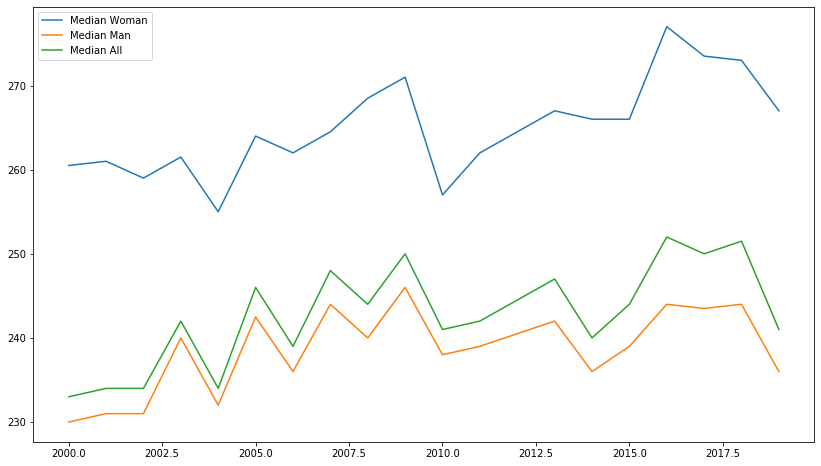

In [34]:
# Now we plot Median times

plt.plot(years, median_w)
plt.plot(years, median_m)
plt.plot(years, median_all)

plt.legend(['Median Woman','Median Man', "Median All"], loc='upper left')
plt.show()

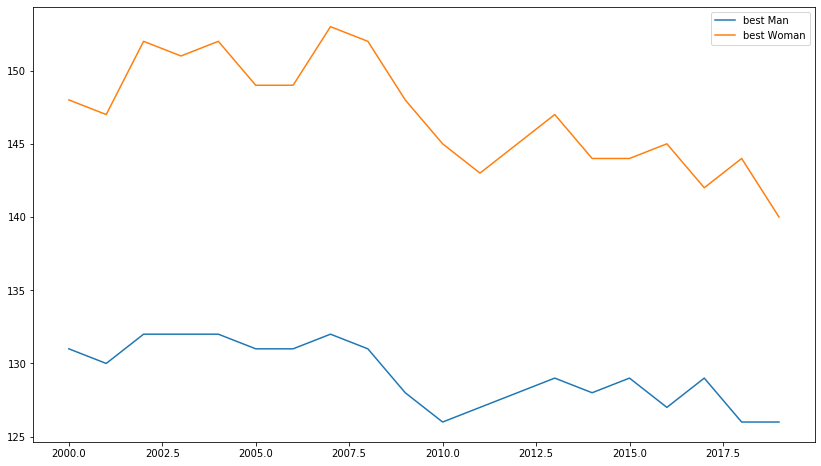

In [35]:
# Top times evolution

plt.plot(years, best_m)
plt.plot(years, best_w)

plt.legend(['best Man','best Woman'], loc='upper right')
plt.show()

### Man x Woman boxplots

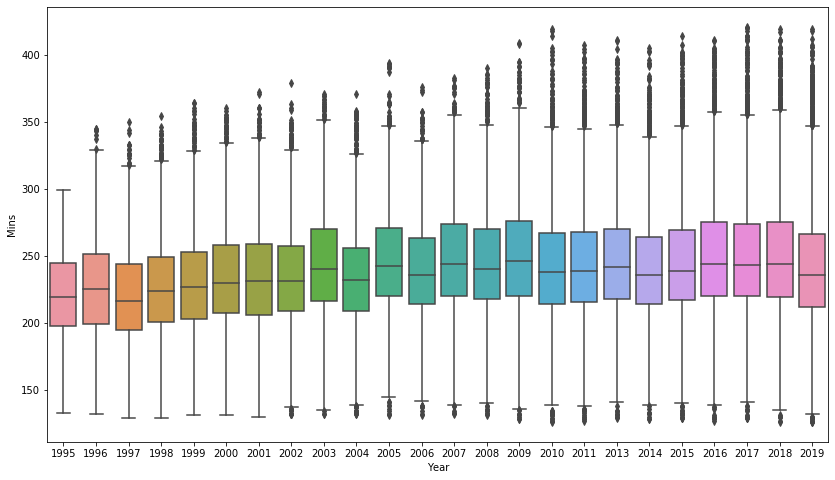

In [36]:
sns.boxplot(x='Year', y='Mins', data=df_man)

# This plot includes all the times over years

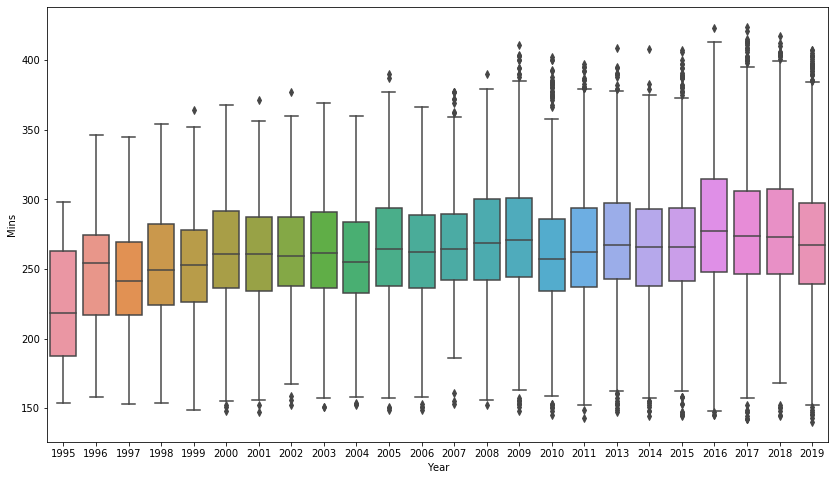

In [37]:
sns.boxplot(x='Year', y='Mins', data=df_woman)

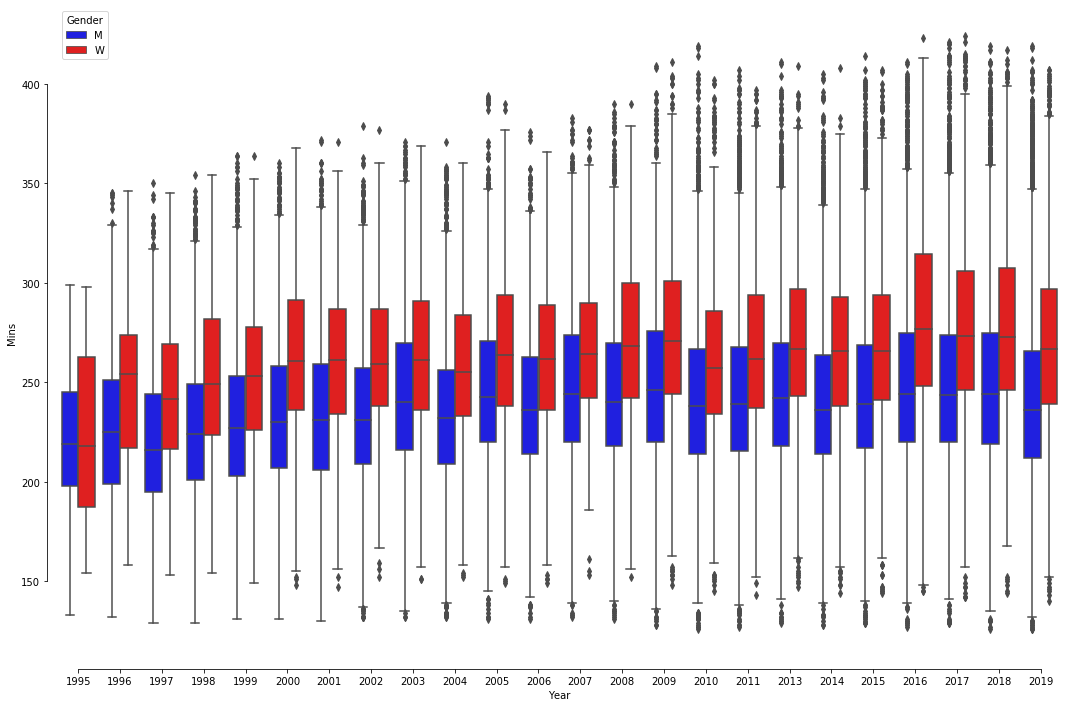

In [38]:
# In this plot there are both Women and Men over years 

plt.rcParams["figure.figsize"]=(18,12)

sns.boxplot(x="Year", y="Mins",
            hue="Gender", palette=["b", "r"],
            data=df_genders)
sns.despine(offset=10, trim=True)

### Histograms
###### Years 1995, 2019 and Total

(array([ 7., 10.,  4.,  4.,  9.,  6.,  6., 20., 17., 16., 21., 23., 35.,
        35., 25., 40., 36., 20., 37., 17., 18., 15., 19.,  7., 16., 12.,
        12.,  8., 13., 11.]),
 array([133.        , 138.53333333, 144.06666667, 149.6       ,
        155.13333333, 160.66666667, 166.2       , 171.73333333,
        177.26666667, 182.8       , 188.33333333, 193.86666667,
        199.4       , 204.93333333, 210.46666667, 216.        ,
        221.53333333, 227.06666667, 232.6       , 238.13333333,
        243.66666667, 249.2       , 254.73333333, 260.26666667,
        265.8       , 271.33333333, 276.86666667, 282.4       ,
        287.93333333, 293.46666667, 299.        ]),
 <a list of 30 Patch objects>)

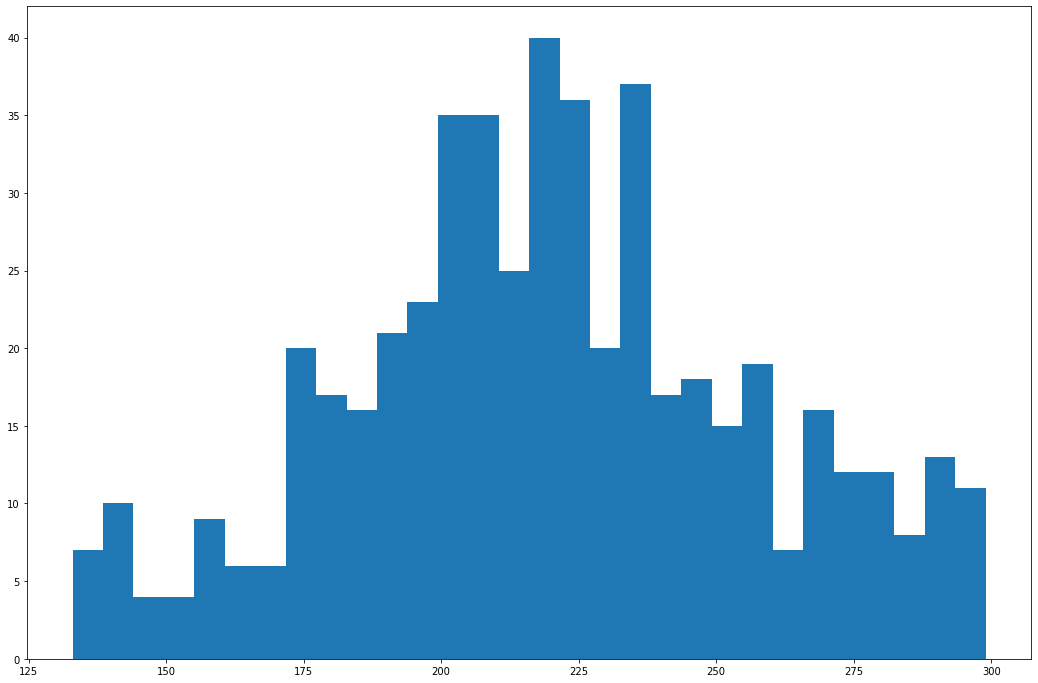

In [39]:
hist_1995 = df_final[df_final["Year"] == 1995].Mins
plt.hist(hist_1995, bins=30)

This Histogram doesn't produce perfect normal distribution due to less amount of Runners and the time limitation of 5 hours.

(array([ 13.,   8.,  16.,  46., 102., 191., 276., 433., 541., 599., 754.,
        778., 530., 559., 515., 404., 353., 282., 157., 159., 140., 111.,
         90.,  80.,  48.,  39.,  34.,  24.,  15.,   3.]),
 array([126.        , 135.76666667, 145.53333333, 155.3       ,
        165.06666667, 174.83333333, 184.6       , 194.36666667,
        204.13333333, 213.9       , 223.66666667, 233.43333333,
        243.2       , 252.96666667, 262.73333333, 272.5       ,
        282.26666667, 292.03333333, 301.8       , 311.56666667,
        321.33333333, 331.1       , 340.86666667, 350.63333333,
        360.4       , 370.16666667, 379.93333333, 389.7       ,
        399.46666667, 409.23333333, 419.        ]),
 <a list of 30 Patch objects>)

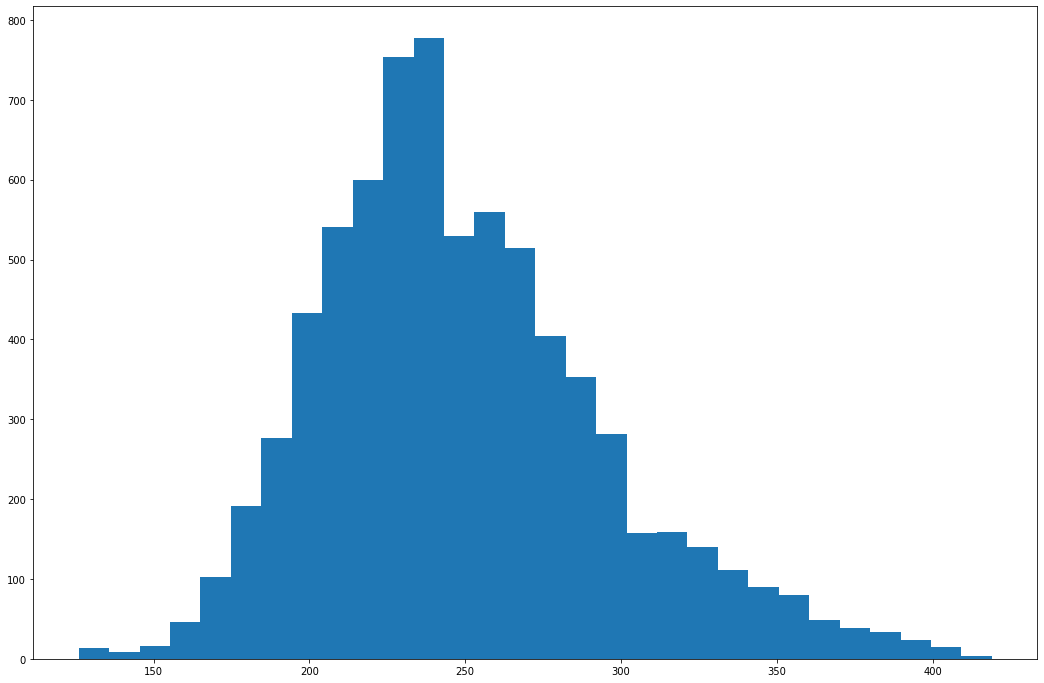

In [40]:
hist_2019 = df_final[df_final["Year"] == 2019].Mins
plt.hist(hist_2019, bins=30)

(array([ 181.,  268.,  339.,  592., 1407., 2542., 3876., 5511., 7487.,
        8597., 9696., 9474., 8104., 7418., 5880., 5362., 4580., 3343.,
        2310., 1997., 1466., 1095.,  845.,  585.,  381.,  258.,  207.,
         136.,   59.,   15.]),
 array([126.        , 135.93333333, 145.86666667, 155.8       ,
        165.73333333, 175.66666667, 185.6       , 195.53333333,
        205.46666667, 215.4       , 225.33333333, 235.26666667,
        245.2       , 255.13333333, 265.06666667, 275.        ,
        284.93333333, 294.86666667, 304.8       , 314.73333333,
        324.66666667, 334.6       , 344.53333333, 354.46666667,
        364.4       , 374.33333333, 384.26666667, 394.2       ,
        404.13333333, 414.06666667, 424.        ]),
 <a list of 30 Patch objects>)

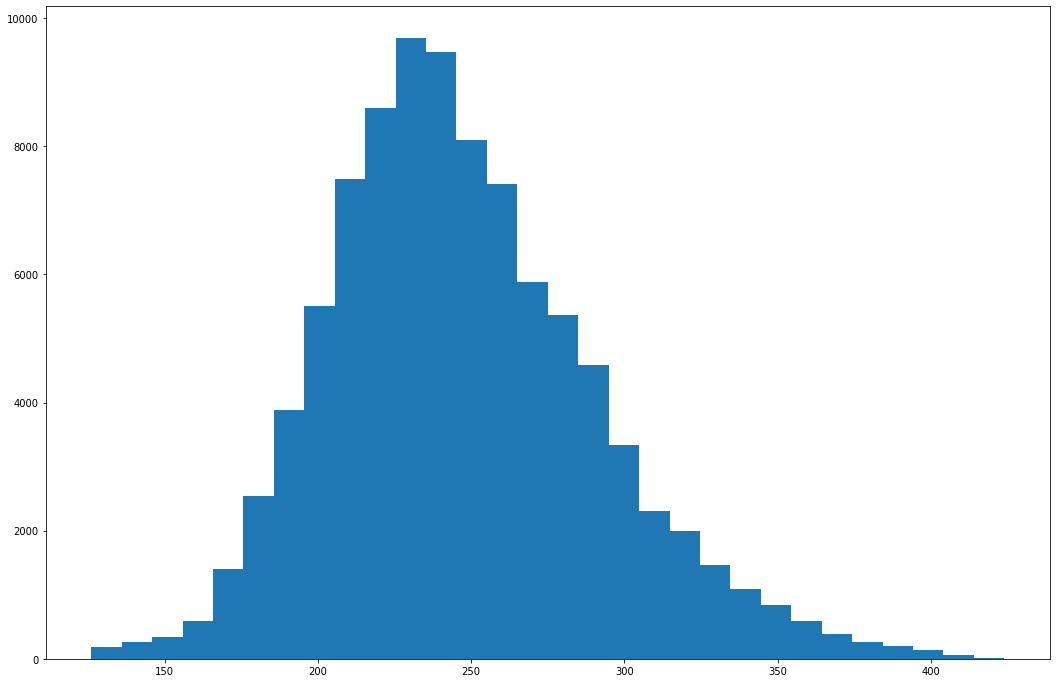

In [41]:
hist_all = df_final.Mins
plt.hist(hist_all, bins=30)

In this case, there is possible bias, because there were different limitations for maximal time of Run over years (5-7 hours)

### Predictions
##### In our Analysis we tried to figure out, whether and when Runners will break 2 hour goal (120 minutes of Run)

In [48]:
years = [1995, 1996,1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
         2005, 2006, 2007, 2008, 2009, 2010, 2011, 
         2013, 2014, 2015, 2016, 2017, 2018, 2019]

# 2012 missing

data_pred = []

for i in years:
    new_pred = df_final[df_final["Year"]== i]
    min_data_pred = new_pred.Mins.min()
    data_pred.append(min_data_pred)
# data_pred

In [43]:
X = years
y = data_pred

gradient,intercept,r_value,p_value,std_err=stats.linregress(X,y)

In [44]:
print("R-squared",r_value**2)

R-squared 0.5099774280676991


In [45]:
gradient

-0.2094848732624694

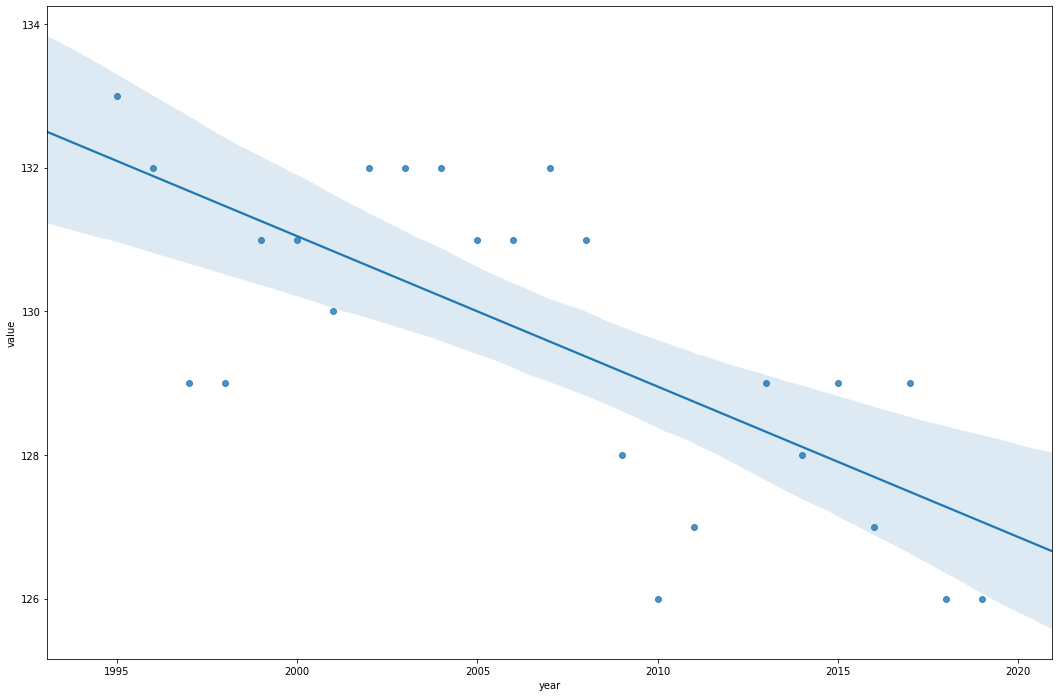

In [46]:
data = pd.DataFrame({'year': X,
                     'value': y})

p = sns.regplot(x='year',y='value',data=data, fit_reg=True)

# Here we get linear regression with standard errors

### Two Hour Goal
##### In this plot we rtry to predict whether the Runners will achieve their time better than 2 hours.
##### If they followed this simple linear trend, it would happen around 2054.

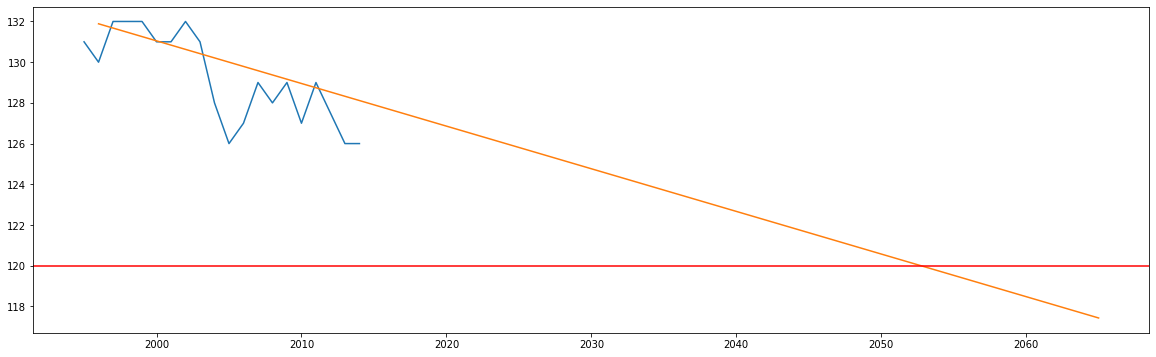

In [47]:
plt.rcParams["figure.figsize"]=(20,6)

plt.plot(years[0:len(years)-5], best_m)
plt.plot([1996, 2065], [intercept + 1996*gradient, intercept+2065*gradient])

plt.axhline(y=120, color='r', linestyle='-')
# plt.legend(['best Man'], loc='upper right')

plt.show()